<br/>
<p style="font-size:36px;text-align:center"> <b>Genetic Mutation Classification for Cancer Treatment</b> </p>
<br/>

<img src="CancerTreatment.jpg" width="700" height="200">

<h1>1. Business Problem</h1>

<h2>1.1. Description</h2>

Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations.

We need your help to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

#### Problem Statement
Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

<h2>1.2. Real-world/Business objectives and constraints.</h2>

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

<h1>2. Machine Learning Problem Formulation</h1>

<h2>2.1. Data</h2>

<h3>2.1.1. Data Overview</h3>

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

<p>
    
            There are nine different classes a genetic mutation can be classified into => Multi class classification problem
   
      
    
</p>

<h3>2.2.2. Performance Metric</h3>

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s): 
* Multi class log-loss 
* Confusion matrix 


<h3>2.2.3. Machine Learing Objectives and Constraints</h3>

<p> Objective: Predict the probability of each data-point belonging to each of the nine classes.
</p>
<p> Constraints:
</p>
* Interpretability
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* No Latency constraints.

<h2>2.3. Train, CV and Test Datasets</h2>

 Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

<h1>3. Exploratory Data Analysis</h1>

In [154]:
#Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

import math
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")


from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


<h2>3.1. Reading Data</h2>

<h3>3.1.1. Reading Gene and Variation Data</h3>

In [155]:
data_variants = pd.read_csv('training_variants')
print('Number of data points : ', data_variants.shape[0])
print('Number of features : ', data_variants.shape[1])
print('Features : ', data_variants.columns.values)
data_variants.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

<h3>3.1.2. Reading Text Data</h3>

In [156]:
# note the seprator in this file
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>3.1.3. Preprocessing of text</h3>

In [157]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [158]:
# Text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 63.71242919999986 seconds


In [159]:
# Merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [160]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [161]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [162]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


<h3>3.1.4. Test, Train and Cross Validation Split</h3>

<h4>3.1.4.1. Splitting data into train, test and cross validation (64:20:16)</h4>

In [163]:
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')
y_true = result[['Class']]
x_true = result.drop(['Class'], axis=1)


print("Feature columns in dataset: ")
print(x_true.head())
print()
print("Target columns in dataset: ")
print(y_true.head())

Feature columns in dataset: 
   ID    Gene             Variation  \
0   0  FAM58A  Truncating_Mutations   
1   1     CBL                 W802*   
2   2     CBL                 Q249E   
3   3     CBL                 N454D   
4   4     CBL                 L399V   

                                                TEXT  
0  cyclin dependent kinases cdks regulate variety...  
1  abstract background non small cell lung cancer...  
2  abstract background non small cell lung cancer...  
3  recent evidence demonstrated acquired uniparen...  
4  oncogenic mutations monomeric casitas b lineag...  

Target columns in dataset: 
   Class
0      1
1      2
2      2
3      3
4      4


In [164]:
# Split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
x_train, x_test, y_train, y_test = train_test_split(x_true, y_true, stratify=y_true, test_size=0.2)

# Split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2)

<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [165]:
print('Number of data points in train data:', x_train.shape[0])
print('Number of data points in test data:', x_test.shape[0])
print('Number of data points in cross validation data:', x_cv.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4>3.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

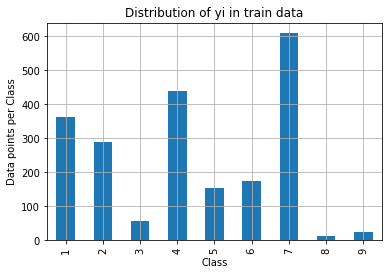

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


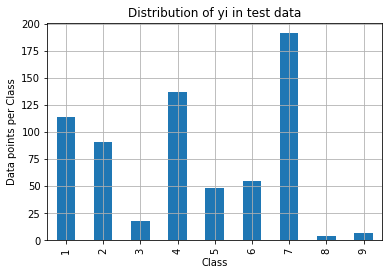

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


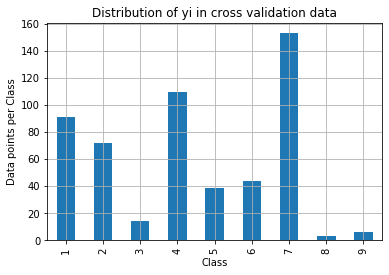

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [166]:
def plot_distribution(class_distribution,title,xlabel,ylabel):
    class_distribution.plot(kind='bar')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()


# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train['Class'].value_counts().sort_index()
test_class_distribution = y_test['Class'].value_counts().sort_index()
cv_class_distribution = y_cv['Class'].value_counts().sort_index()

plot_distribution(train_class_distribution,
                 'Distribution of yi in train data',
                 'Class',
                 'Data points per Class')

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], 
          '(', np.round((train_class_distribution.values[i]/x_train.shape[0]*100), 3), '%)')
    
print('-'*80)



plot_distribution(test_class_distribution,
                 'Distribution of yi in test data',
                 'Class',
                 'Data points per Class')


sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], 
          '(', np.round((test_class_distribution.values[i]/x_test.shape[0]*100), 3), '%)')

print('-'*80)



plot_distribution(cv_class_distribution,
                 'Distribution of yi in cross validation data',
                 'Class',
                 'Data points per Class')


sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], 
          '(', np.round((cv_class_distribution.values[i]/x_cv.shape[0]*100), 3), '%)')


<h2>3.2 Prediction using a 'Random' Model</h2>

<p style="font-size:16px"> In a 'Random' Model, we generate the '9' class probabilites randomly such that they sum to 1. </p>

In [167]:
def plot_matrix(matrix,labels):
    plt.figure(figsize=(20,7))    
    sns.heatmap(matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    cm = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    precision_table =(cm/cm.sum(axis=0))
    # How did we calculateed precision_table :
    # divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    recall_table =(((cm.T)/(cm.sum(axis=1))).T)
    # How did we calculateed recall_table :
    # divide each element of the confusion matrix with the sum of elements in that column    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]
    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    

    
    labels = [1,2,3,4,5,6,7,8,9]    
    print()
    print("-"*20, "Confusion matrix", "-"*20)
    plot_matrix(cm,labels)

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plot_matrix(precision_table,labels)    
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plot_matrix(recall_table,labels)

Log loss on Cross Validation Data using Random Model 2.503885215296168
Log loss on Test Data using Random Model 2.5063122832275937

-------------------- Confusion matrix --------------------


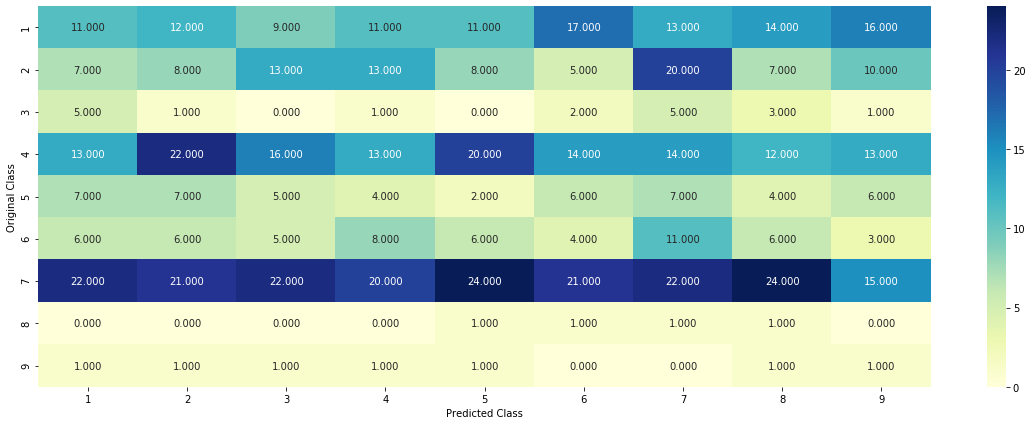

-------------------- Precision matrix (Columm Sum=1) --------------------


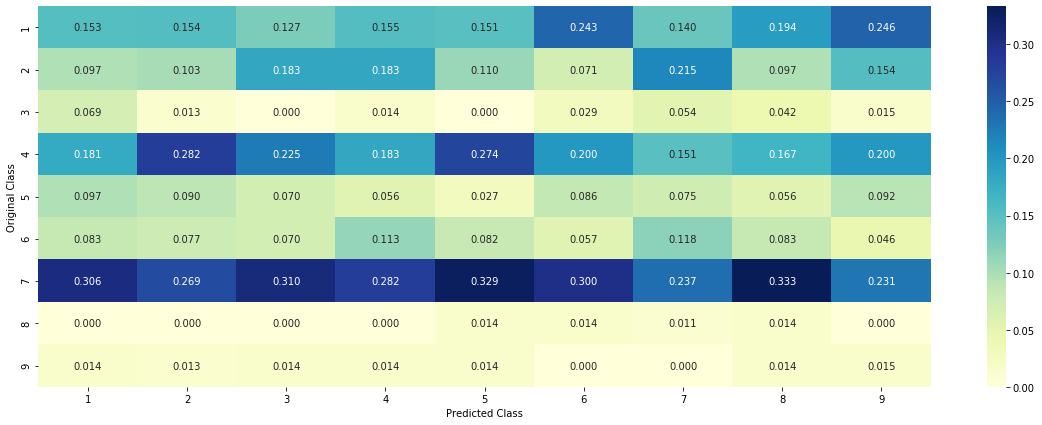

-------------------- Recall matrix (Row sum=1) --------------------


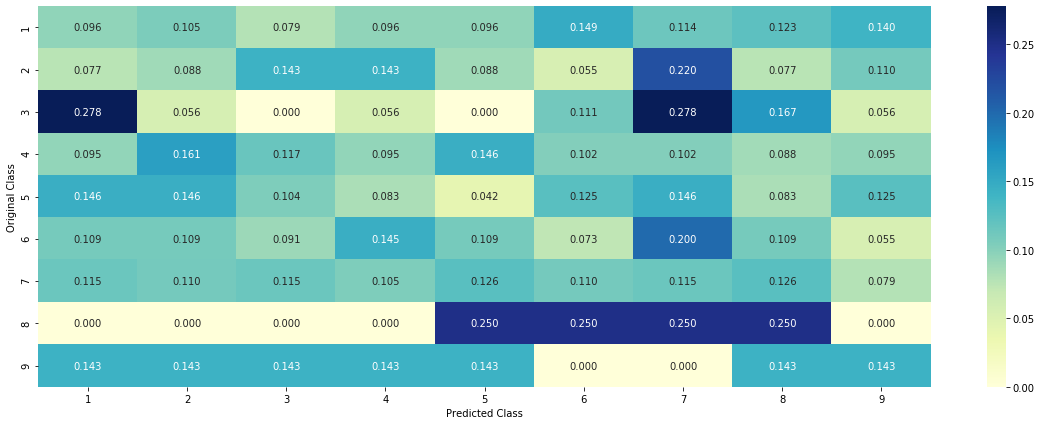

In [168]:
# We need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = x_test.shape[0]
cv_data_len = x_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
# We create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<h2>3.3 Univariate Analysis</h2>

<h3>3.1.1 Univariate Analysis on Gene Feature</h3>

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [170]:
unique_genes = x_train['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 234
BRCA1     174
TP53       99
EGFR       91
BRCA2      83
PTEN       83
BRAF       68
KIT        63
ALK        44
ERBB2      39
PDGFRA     36
Name: Gene, dtype: int64


In [171]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 234 different categories of genes in the train data, and they are distibuted as follows


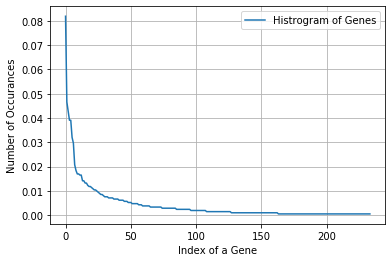

In [172]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


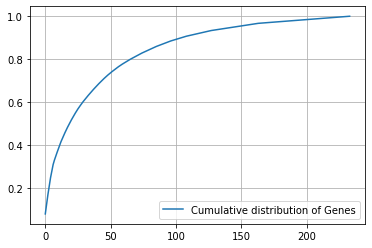

In [173]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>We can featurize this variable with TfidfVectorizer


In [174]:
# Converting text into number for Gene feature.
gene_vectorizer = TfidfVectorizer()
train_gene_feature = gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_feature = gene_vectorizer.transform(x_test['Gene'])
cv_gene_feature = gene_vectorizer.transform(x_cv['Gene'])

In [175]:
train_gene_feature

<2124x234 sparse matrix of type '<class 'numpy.float64'>'
	with 2124 stored elements in Compressed Sparse Row format>

In [176]:
print("The shape of gene feature:", train_gene_feature.shape)

The shape of gene feature: (2124, 234)


<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.2405821382523248
For values of alpha =  0.0001 The log loss is: 1.220990894046097
For values of alpha =  0.001 The log loss is: 1.2648541931390065
For values of alpha =  0.01 The log loss is: 1.3882465509892539
For values of alpha =  0.1 The log loss is: 1.4690547386462036
For values of alpha =  1 The log loss is: 1.4943381614398752


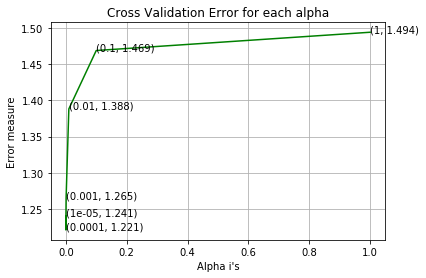

For values of best alpha =  0.0001 The train log loss is: 0.9874735590403488
For values of best alpha =  0.0001 The cross validation log loss is: 1.220990894046097
For values of best alpha =  0.0001 The test log loss is: 1.1942916493229088


In [179]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparameter for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_gene_feature)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_gene_feature)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [180]:
print("Q6. How many data points in Test and CV datasets are covered by the ", 
      unique_genes.shape[0], " genes in train dataset?")

test_coverage=x_test[x_test['Gene'].isin(list(set(x_train['Gene'])))].shape[0]
cv_coverage=x_cv[x_cv['Gene'].isin(list(set(x_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',x_test.shape[0], ":",(test_coverage/x_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',x_cv.shape[0],":" ,(cv_coverage/x_cv.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  234  genes in train dataset?
Ans
1. In test data 645 out of 665 : 96.99248120300751
2. In cross validation data 517 out of  532 : 97.18045112781954


<h3>3.2.2 Univariate Analysis on Variation Feature</h3>

<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [181]:
unique_variations = x_train['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1933
Truncating_Mutations    56
Deletion                47
Amplification           45
Fusions                 20
Overexpression           5
G12V                     3
Q61L                     3
E17K                     3
Y64A                     2
T58I                     2
Name: Variation, dtype: int64


In [182]:
print("Ans: There are", unique_variations.shape[0] ,
      "different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1933 different categories of variations in the train data, and they are distibuted as follows


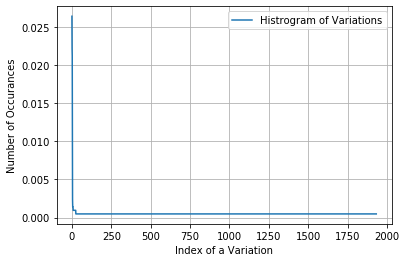

In [183]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02636535 0.04849341 0.06967985 ... 0.99905838 0.99952919 1.        ]


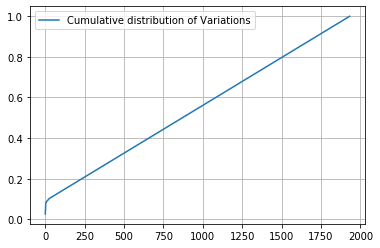

In [184]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>We can featurize this variable with TfidfVectorizer


In [185]:
# one-hot encoding of variation feature.
variation_vectorizer = TfidfVectorizer()
train_variation_feature = variation_vectorizer.fit_transform(x_train['Variation'])
test_variation_feature = variation_vectorizer.transform(x_test['Variation'])
cv_variation_feature = variation_vectorizer.transform(x_cv['Variation'])

In [187]:
print("The shape of Variation feature:",train_variation_feature.shape)

The shape of Variation feature: (2124, 1965)


<p style="font-size:18px;"> <b>Q10.</b> How good is this Variation feature  in predicting y_i?</p>

Let's build a model just like the earlier!

For values of alpha =  1e-05 The log loss is: 1.7140866811071942
For values of alpha =  0.0001 The log loss is: 1.7095208220897835
For values of alpha =  0.001 The log loss is: 1.7075783761172025
For values of alpha =  0.01 The log loss is: 1.7135404129228802
For values of alpha =  0.1 The log loss is: 1.7266317401563251
For values of alpha =  1 The log loss is: 1.728436935151549


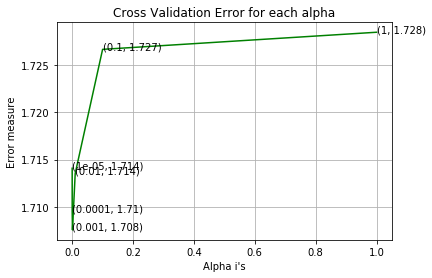

For values of best alpha =  0.001 The train log loss is: 1.0736145315911698
For values of best alpha =  0.001 The cross validation log loss is: 1.7075783761172025
For values of best alpha =  0.001 The test log loss is: 1.7018259197034233


In [188]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature, y_train)    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature)    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [189]:
print("Q12. How many data points are covered by total ", 
      unique_variations.shape[0], 
      " genes in test and cross validation data sets?")
test_coverage=x_test[x_test['Variation'].isin(list(set(x_train['Variation'])))].shape[0]
cv_coverage=x_cv[x_cv['Variation'].isin(list(set(x_train['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',x_test.shape[0], ":",(test_coverage/x_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',x_cv.shape[0],":" ,(cv_coverage/x_cv.shape[0])*100)

Q12. How many data points are covered by total  1933  genes in test and cross validation data sets?
Ans
1. In test data 71 out of 665 : 10.676691729323307
2. In cross validation data 58 out of  532 : 10.902255639097744


<h3>3.2.3 Univariate Analysis on Text Feature</h3>

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [107]:
x_train['TEXT'].head()

549     ligand induced phosphorylation receptor regula...
178     selected patients advanced non small cell lung...
41      mesenchymal cell populations contribute microe...
2497    abstract brca1 gene individuals risk breast ov...
306     dna entry exit points nucleosome core regulate...
Name: TEXT, dtype: object

In [190]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, min_tfidf=0.1, grp_ids=None, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [192]:
# building a TfidfVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature = text_vectorizer.fit_transform(x_train['TEXT'])

# getting top 1000 feature names (words)
train_text_features = top_mean_feats(train_text_feature,
                                                text_vectorizer.get_feature_names(),
                                                top_n=1000)['feature'].tolist()

In [193]:
# train_text_feature.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature.sum(axis=0).A1
train_text_fea_counts

array([9.29928541, 9.2747175 , 0.02417199, ..., 0.05862618, 0.03725075,
       0.07576696])

In [194]:
# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [197]:
# don't forget to normalize every feature
train_text_feature = normalize(train_text_feature, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature = text_vectorizer.transform(x_test['TEXT'])
# don't forget to normalize every feature
test_text_feature = normalize(test_text_feature, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature = text_vectorizer.transform(x_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature = normalize(cv_text_feature, axis=0)

In [198]:
#Let's see the most occuring words and the number of times they occur
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [199]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({0.022347662165914387: 27, 0.027423583508295858: 22, 0.08223211173175586: 17, 0.03674783063306147: 9, 0.020280684435655158: 8, 0.01957857973538108: 7, 0.009734150139731747: 7, 0.3430365419260862: 6, 0.23400884257255206: 6, 0.03132933815884828: 6, 0.023197279070869867: 5, 0.07349566126612295: 4, 0.04126986889779682: 4, 0.01944510681642672: 4, 0.11182085508847463: 3, 0.07728900932702769: 3, 0.054847167016591716: 3, 0.04158108374506352: 3, 0.028513717627181363: 3, 0.02687724656121488: 3, 0.025865265988792567: 3, 0.02043030977890832: 3, 0.010068531902152502: 3, 0.14536987069965132: 2, 0.1102434918991844: 2, 0.07574606383487252: 2, 0.07513474874633896: 2, 0.051809929502870805: 2, 0.0444933285609318: 2, 0.044288938080972576: 2, 0.04358785938577372: 2, 0.040561368871310316: 2, 0.03240147614151442: 2, 0.02939053610623672: 2, 0.02618959474979306: 2, 0.024698822917961286: 2, 0.024507766411003273: 2, 0.024208678619457014: 2, 0.0231891615795412: 2, 0.019262754185084763: 2, 0.01350524132232

For values of alpha =  1e-05 The log loss is: 1.2297182944774812
For values of alpha =  0.0001 The log loss is: 1.076859651610009
For values of alpha =  0.001 The log loss is: 1.0879789528911556
For values of alpha =  0.01 The log loss is: 1.194074874139401
For values of alpha =  0.1 The log loss is: 1.3835584617607946
For values of alpha =  1 The log loss is: 1.6023173395035077


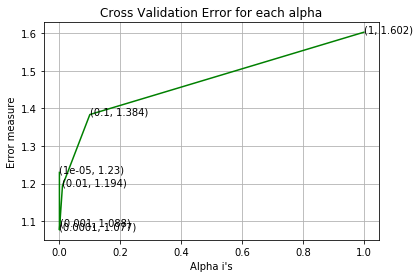

For values of best alpha =  0.0001 The train log loss is: 0.6215406302514682
For values of best alpha =  0.0001 The cross validation log loss is: 1.076859651610009
For values of best alpha =  0.0001 The test log loss is: 1.1283331671218746


In [200]:
# Train a Logistic regression+Calibration model
alpha = [10 ** x for x in range(-5, 1)]



cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature, y_train)

predict_y = sig_clf.predict_proba(train_text_feature)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [201]:
def get_intersec_text(df):
    df_text_vec = TfidfVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])   
    
    df_text_features = top_mean_feats(df_text_fea,
                                      df_text_vec.get_feature_names(),
                                      top_n=1000)['feature'].tolist()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [202]:
len1,len2 = get_intersec_text(x_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(x_cv)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

63.0 % of word of test data appeared in train data
60.1 % of word of Cross Validation appeared in train data


<h1>4. Machine Learning Models</h1>

In [203]:
#Data preparation for ML models.

#Misc. functionns for ML models

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [214]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [215]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = TfidfVectorizer()
    var_count_vec = TfidfVectorizer()
    text_count_vec = TfidfVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(x_train['Gene'])
    var_vec  = var_count_vec.fit(x_train['Variation'])
    text_vec = text_count_vec.fit(x_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:            
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<br/>
<p style="font-size:24px;text-align:left"> <b>Stacking the three types of features </b><p>
<br/>

In [216]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var = hstack((train_gene_feature,train_variation_feature))
test_gene_var = hstack((test_gene_feature,test_variation_feature))
cv_gene_var = hstack((cv_gene_feature,cv_variation_feature))

train_x= hstack((train_gene_var, train_text_feature)).tocsr()
train_y = np.array(list(y_train['Class']))

test_x = hstack((test_gene_var, test_text_feature)).tocsr()
test_y = np.array(list(y_test['Class']))

cv_x = hstack((cv_gene_var, cv_text_feature)).tocsr()
cv_y = np.array(list(y_cv['Class']))


In [217]:
print("(number of data points * number of features) in train data = ", train_x.shape)
print("(number of data points * number of features) in test data = ", test_x.shape)
print("(number of data points * number of features) in cross validation data =", cv_x.shape)

(number of data points * number of features) in train data =  (2124, 54972)
(number of data points * number of features) in test data =  (665, 54972)
(number of data points * number of features) in cross validation data = (532, 54972)


<h2>4.1. Base Line Model</h2>

<h3>4.1.1. Naive Bayes</h3>

<h4>4.1.1.1. Hyper parameter tuning</h4>

for alpha = 1e-05
Log Loss : 1.2424166551052085
for alpha = 0.0001
Log Loss : 1.2344206451195325
for alpha = 0.001
Log Loss : 1.227315534242891
for alpha = 0.1
Log Loss : 1.2344951907693784
for alpha = 1
Log Loss : 1.2439491733845947
for alpha = 10
Log Loss : 1.3662675552996288
for alpha = 100
Log Loss : 1.2670354113944262
for alpha = 1000
Log Loss : 1.2127506039548297


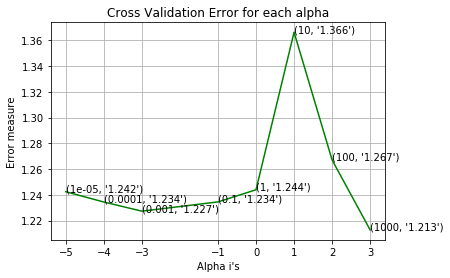

For values of best alpha =  1000 The train log loss is: 0.9384213808228382
For values of best alpha =  1000 The cross validation log loss is: 1.2127506039548297
For values of best alpha =  1000 The test log loss is: 1.235723463743155


In [218]:

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)


predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h4>4.1.1.2. Testing the model with best hyper paramters</h4>

Log Loss : 1.235723463743155
Number of missclassified point : 0.4255639097744361

-------------------- Confusion matrix --------------------


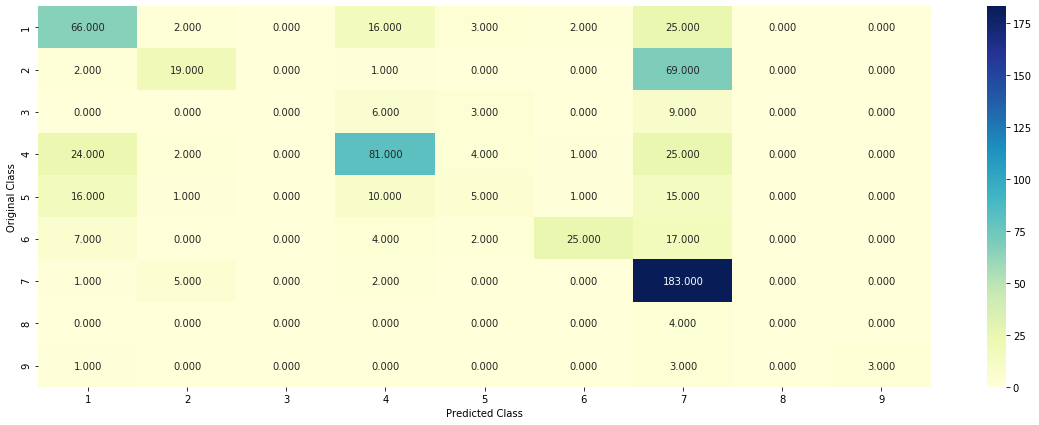

-------------------- Precision matrix (Columm Sum=1) --------------------


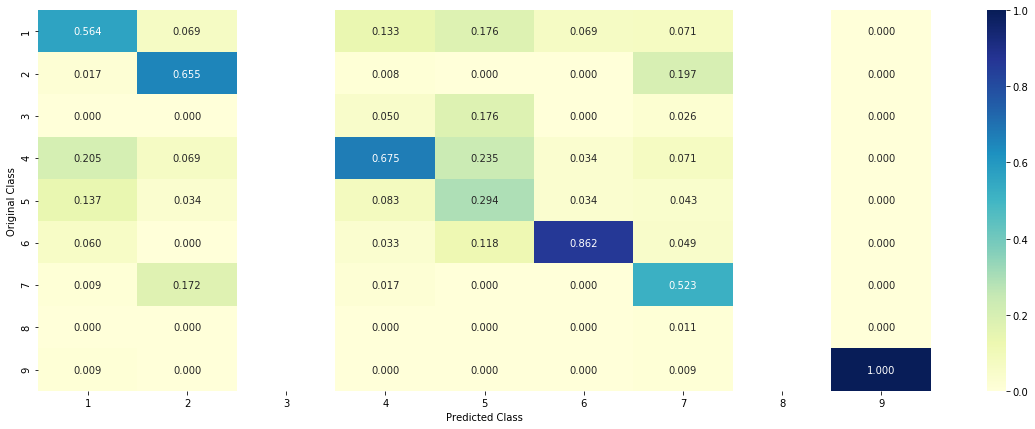

-------------------- Recall matrix (Row sum=1) --------------------


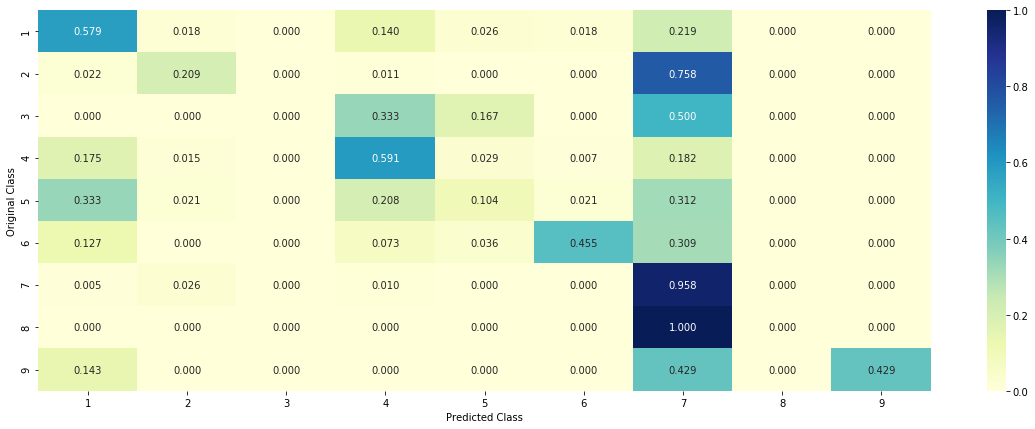

In [219]:

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)
sig_clf_probs = sig_clf.predict_proba(test_x)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(test_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(test_x)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y, sig_clf.predict(test_x.toarray()))

<h4>4.1.1.3. Feature Importance, Correctly classified point</h4>

In [220]:
test_point_index = 1
no_feature = 1000
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[7.660e-02 1.190e-02 5.500e-03 3.581e-01 4.940e-02 4.637e-01 3.090e-02
  3.400e-03 4.000e-04]]
Actual Class : 6
--------------------------------------------------
9 Text feature [brca] present in test data point [True]
12 Text feature [basis] present in test data point [True]
18 Text feature [deleterious] present in test data point [True]
19 Text feature [personal] present in test data point [True]
21 Text feature [classified] present in test data point [True]
23 Text feature [i124v] present in test data point [True]
26 Text feature [family] present in test data point [True]
27 Text feature [sequence] present in test data point [True]
30 Text feature [history] present in test data point [True]
31 Text feature [predicted] present in test data point [True]
41 Text feature [classify] present in test data point [True]
241 Text feature [expected] present in test data point [True]
256 Text feature [000] present in test data point [True]
258

<h4>4.1.1.4. Feature Importance, Incorrectly classified point</h4>

In [223]:
test_point_index = 58
no_feature = 1000
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.2482 0.0986 0.0049 0.1143 0.0253 0.0296 0.4735 0.005  0.0007]]
Actual Class : 1
--------------------------------------------------
17 Text feature [cells] present in test data point [True]
18 Text feature [kinase] present in test data point [True]
20 Text feature [activation] present in test data point [True]
21 Text feature [cell] present in test data point [True]
22 Text feature [activated] present in test data point [True]
23 Text feature [downstream] present in test data point [True]
24 Text feature [contrast] present in test data point [True]
25 Text feature [expressing] present in test data point [True]
26 Text feature [presence] present in test data point [True]
28 Text feature [factor] present in test data point [True]
29 Text feature [shown] present in test data point [True]
30 Text feature [also] present in test data point [True]
31 Text feature [recently] present in test data point [True]
33 Text feature [inhibitor] pres

<h2>4.2. K Nearest Neighbour Classification</h2>

<h3>4.2.1. Hyper parameter tuning</h3>

for alpha = 1
Log Loss : 1.3710471054178546
for alpha = 3
Log Loss : 1.3006330191408422
for alpha = 5
Log Loss : 1.2802914568440718
for alpha = 11
Log Loss : 1.3103651992873162
for alpha = 15
Log Loss : 1.3792447640541505
for alpha = 21
Log Loss : 1.4599110947265217
for alpha = 31
Log Loss : 1.4945931529629903
for alpha = 41
Log Loss : 1.5158976113072764
for alpha = 51
Log Loss : 1.5101433758133005


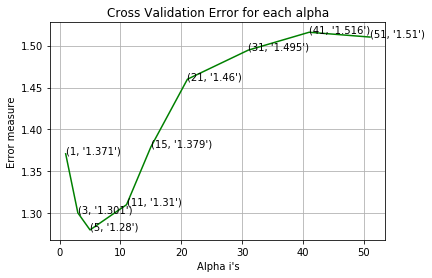

For values of best alpha =  5 The train log loss is: 0.9918856770887512
For values of best alpha =  5 The cross validation log loss is: 1.2802914568440718
For values of best alpha =  5 The test log loss is: 1.328135451747633


In [224]:
alpha = [1, 3, 5, 11, 15, 21, 31, 41, 51]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_,eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>4.2.2. Testing the model with best hyper paramters</h3>

Log loss : 1.328135451747633
Number of mis-classified points : 0.4421052631578947

-------------------- Confusion matrix --------------------


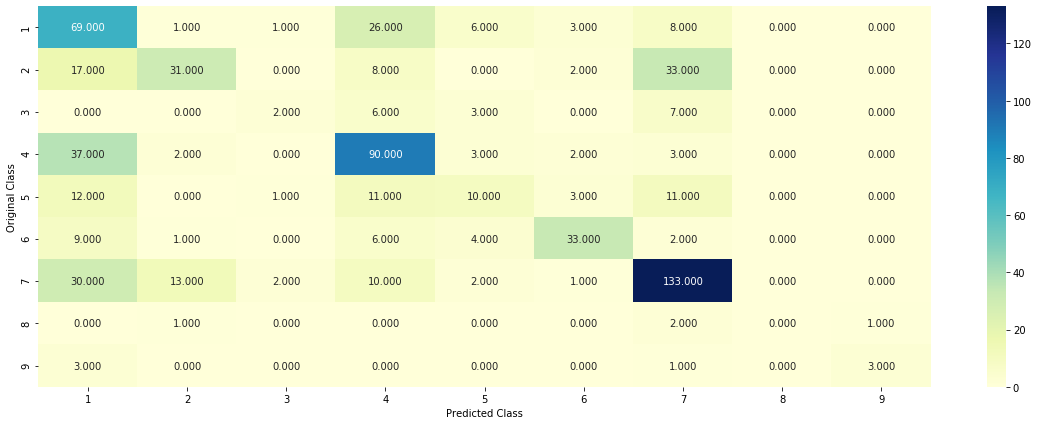

-------------------- Precision matrix (Columm Sum=1) --------------------


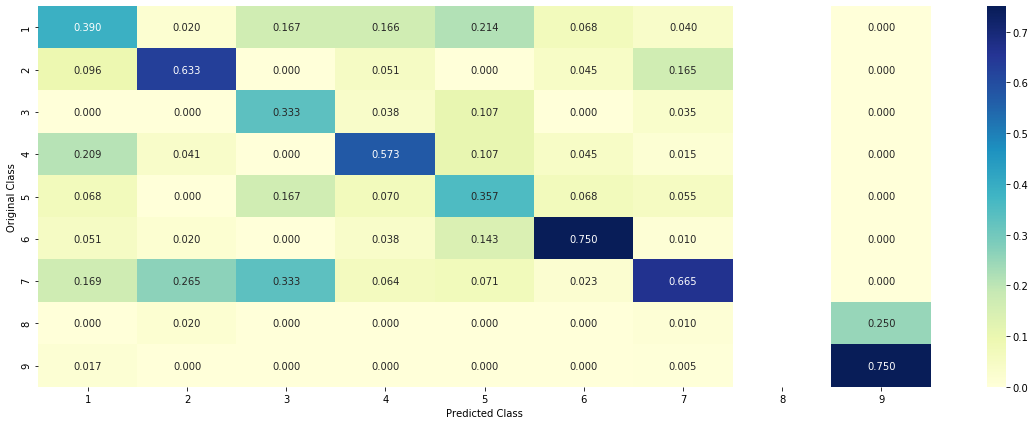

-------------------- Recall matrix (Row sum=1) --------------------


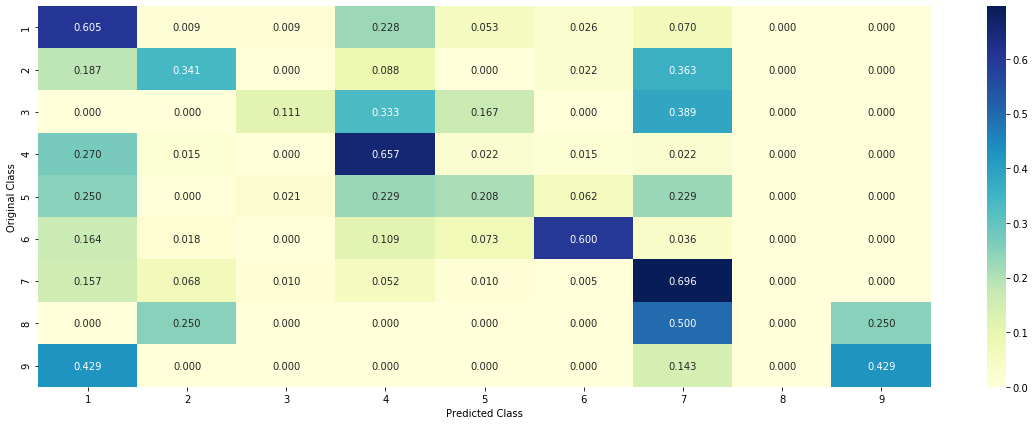

In [225]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf)

<h3>4.2.3.Sample Query point -1</h3>

In [227]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 6
The  5  nearest neighbours of the test points belongs to classes [6 6 6 6 6]
Fequency of nearest points : Counter({6: 5})


<h3>4.2.4. Sample Query Point-2 </h3>

In [228]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [4 4 1 4 4]
Fequency of nearest points : Counter({4: 4, 1: 1})


<h2>4.3. Logistic Regression</h2>

<h3>4.3.1. With Class balancing</h3>

<h4>4.3.1.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.2539487972141607
for alpha = 1e-05
Log Loss : 1.2094943088544152
for alpha = 0.0001
Log Loss : 1.0194198452478178
for alpha = 0.001
Log Loss : 1.0059496240543644
for alpha = 0.01
Log Loss : 1.067178300158969
for alpha = 0.1
Log Loss : 1.2619626657409777
for alpha = 1
Log Loss : 1.4750371867639027
for alpha = 10
Log Loss : 1.5093865516389169
for alpha = 100
Log Loss : 1.5131943558008623


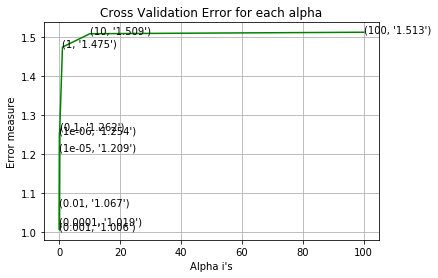

For values of best alpha =  0.001 The train log loss is: 0.5014108411540469
For values of best alpha =  0.001 The cross validation log loss is: 1.0059496240543644
For values of best alpha =  0.001 The test log loss is: 1.0818531246972793


In [229]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.3.1.2. Testing the model with best hyper paramters</h4>

Log loss : 1.0818531246972793
Number of mis-classified points : 0.36541353383458647

-------------------- Confusion matrix --------------------


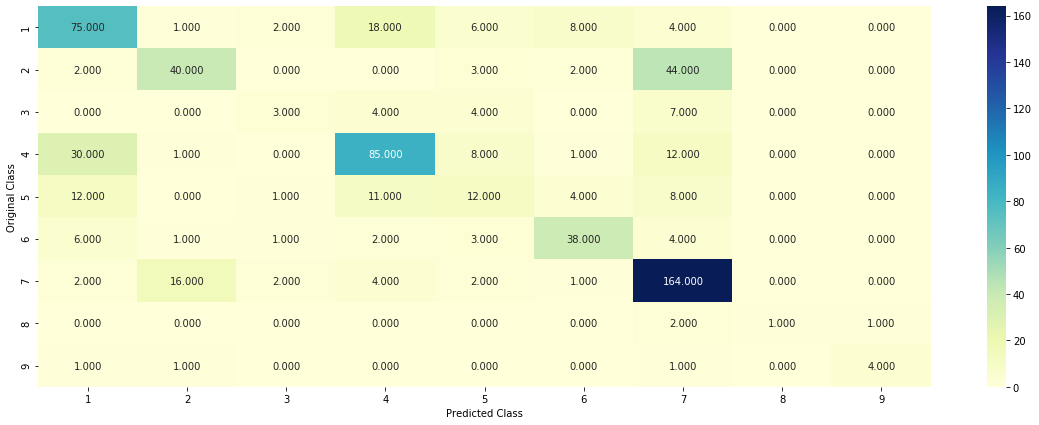

-------------------- Precision matrix (Columm Sum=1) --------------------


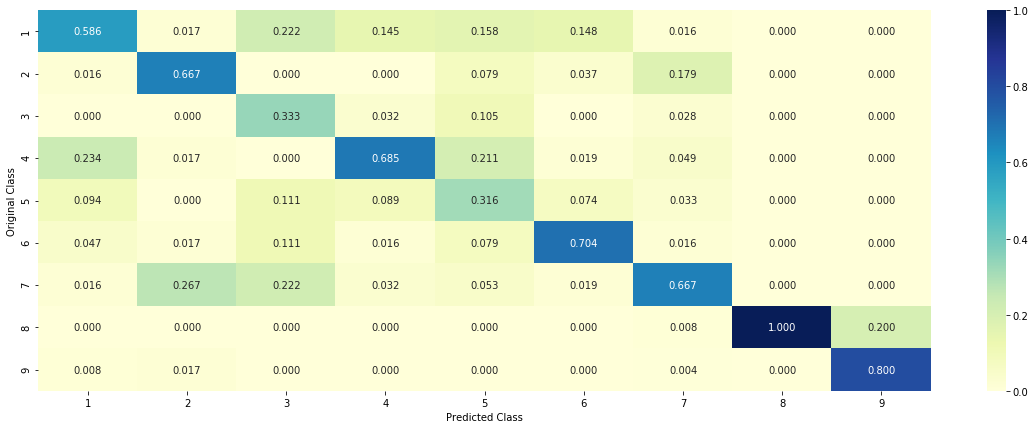

-------------------- Recall matrix (Row sum=1) --------------------


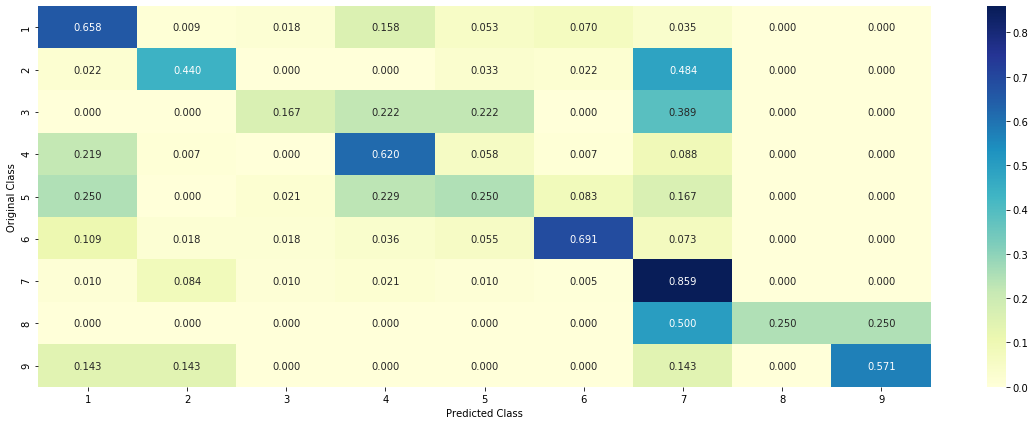

In [245]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf)

<h4>4.3.1.3. Feature Importance</h4>

In [231]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

<h5>4.3.1.3.1. Correctly Classified point</h5>

In [232]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x,train_y)
test_point_index = 1
no_feature = 1000
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0046 0.0078 0.0055 0.0712 0.0052 0.8972 0.0038 0.0036 0.0011]]
Actual Class : 6
--------------------------------------------------
159 Text feature [logged] present in test data point [True]
237 Text feature [k4] present in test data point [True]
280 Text feature [leaves] present in test data point [True]
281 Text feature [spermatogenesis] present in test data point [True]
322 Text feature [theoretical] present in test data point [True]
328 Text feature [weakened] present in test data point [True]
345 Text feature [s80] present in test data point [True]
354 Text feature [ambiguous] present in test data point [True]
424 Text feature [ccdc98] present in test data point [True]
436 Text feature [triazole] present in test data point [True]
502 Text feature [sterility] present in test data point [True]
578 Text feature [1jm7] present in test data point [True]
586 Text feature [fails] present in test data point [True]
588 Text feature [br

<h5>4.3.1.3.2. Incorrectly Classified point</h5>

In [236]:
test_point_index = 7
no_feature = 1000
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.0268 0.0931 0.0014 0.0018 0.5326 0.0024 0.333  0.0079 0.0008]]
Actual Class : 2
--------------------------------------------------
176 Text feature [253j] present in test data point [True]
251 Text feature [cystectomy] present in test data point [True]
281 Text feature [improvements] present in test data point [True]
314 Text feature [passaged] present in test data point [True]
356 Text feature [ecds] present in test data point [True]
400 Text feature [tccsup] present in test data point [True]
411 Text feature [protrusions] present in test data point [True]
442 Text feature [hydrocortisone] present in test data point [True]
515 Text feature [radical] present in test data point [True]
534 Text feature [vm] present in test data point [True]
580 Text feature [y1197] present in test data point [True]
750 Text feature [horse] present in test data point [True]
757 Text feature [occurring] present in test data point [True]
765 Text featur

<h3>4.3.2. Without Class balancing</h3>

<h4>4.3.2.1. Hyper paramter tuning</h4>

for alpha = 1e-06
Log Loss : 1.2004500343600626
for alpha = 1e-05
Log Loss : 1.1805954031606212
for alpha = 0.0001
Log Loss : 1.035726179983868
for alpha = 0.001
Log Loss : 1.0356781943936317
for alpha = 0.01
Log Loss : 1.129979692271718
for alpha = 0.1
Log Loss : 1.3098929514208473
for alpha = 1
Log Loss : 1.5070896469444526


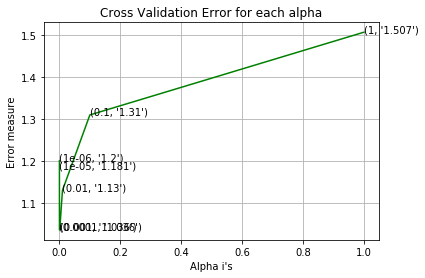

For values of best alpha =  0.001 The train log loss is: 0.4997343764572617
For values of best alpha =  0.001 The cross validation log loss is: 1.0356781943936317
For values of best alpha =  0.001 The test log loss is: 1.0898233767808878


In [237]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.3.2.2. Testing model with best hyper parameters</h4>

Log loss : 1.0898233767808878
Number of mis-classified points : 0.3609022556390977

-------------------- Confusion matrix --------------------


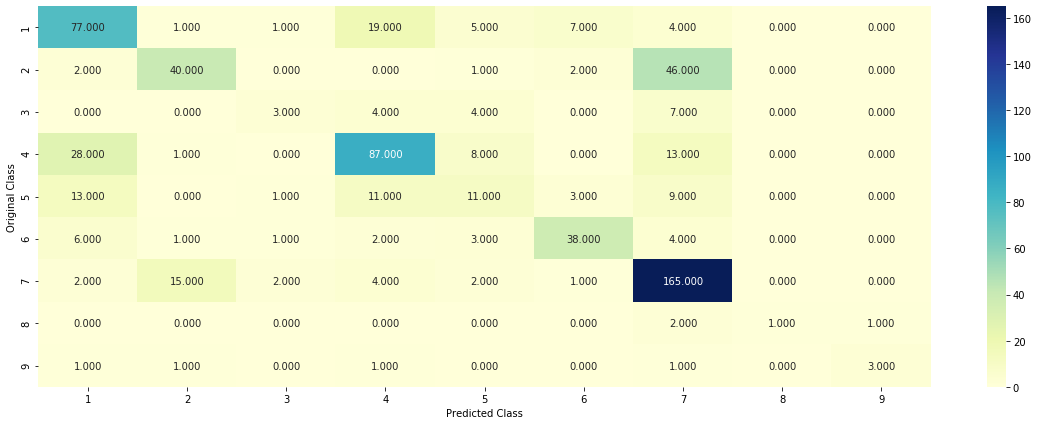

-------------------- Precision matrix (Columm Sum=1) --------------------


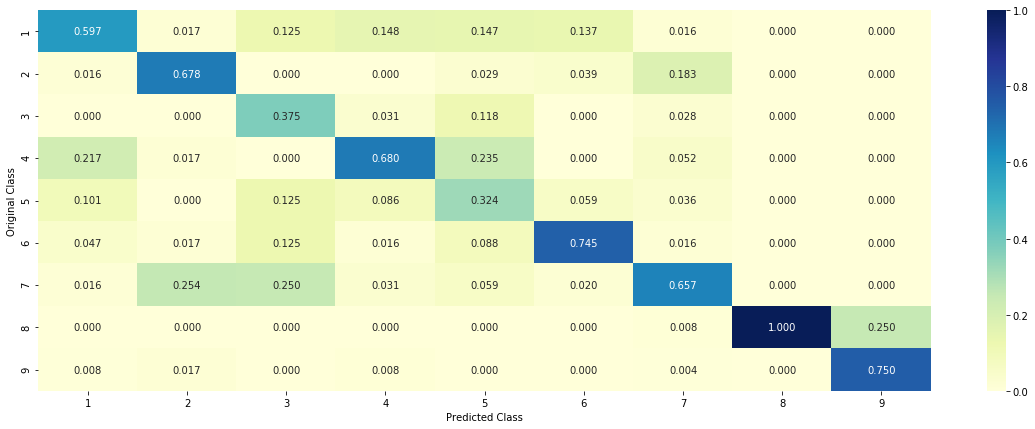

-------------------- Recall matrix (Row sum=1) --------------------


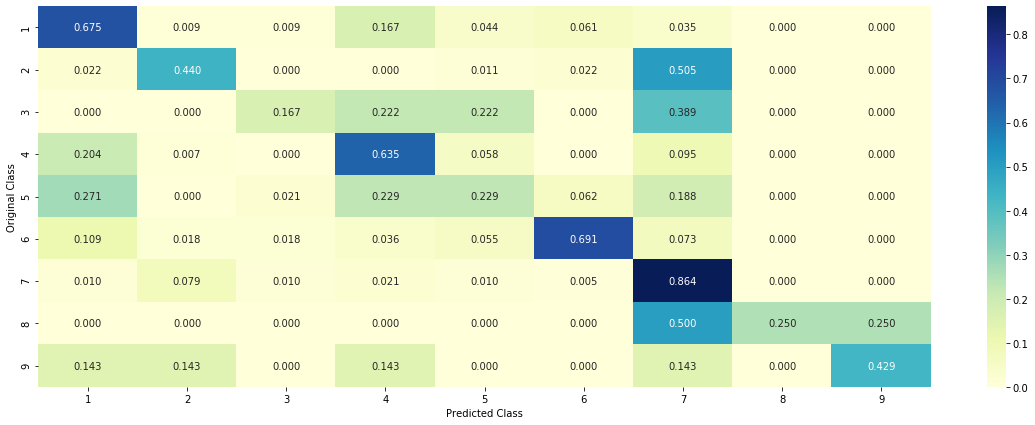

In [238]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf)

<h4>4.3.2.3. Feature Importance, Correctly Classified point</h4>

In [239]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x,train_y)
test_point_index = 100
no_feature = 1000
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index],
                     no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[2.832e-01 1.120e-02 2.400e-03 6.719e-01 9.100e-03 5.400e-03 1.370e-02
  2.600e-03 4.000e-04]]
Actual Class : 4
--------------------------------------------------
108 Text feature [precipitate] present in test data point [True]
212 Text feature [proteasome] present in test data point [True]
218 Text feature [degrade] present in test data point [True]
234 Text feature [y98h] present in test data point [True]
245 Text feature [suppressor] present in test data point [True]
248 Text feature [hep3b] present in test data point [True]
250 Text feature [biallelic] present in test data point [True]
338 Text feature [elongins] present in test data point [True]
379 Text feature [cullin] present in test data point [True]
381 Text feature [nonidet] present in test data point [True]
405 Text feature [subcomplex] present in test data point [True]
415 Text feature [degradation] present in test data point [True]
448 Text feature [ligases] present in t

<h4>4.3.2.4. Feature Importance, Inorrectly Classified point</h4>

In [241]:
test_point_index = 2
no_feature = 1000
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index],
                     no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[1.520e-02 7.454e-01 4.000e-04 3.620e-02 4.000e-03 5.200e-03 1.908e-01
  2.700e-03 0.000e+00]]
Actual Class : 7
--------------------------------------------------
129 Text feature [cases1] present in test data point [True]
166 Text feature [achieved] present in test data point [True]
196 Text feature [balanced] present in test data point [True]
224 Text feature [vp] present in test data point [True]
322 Text feature [bindings] present in test data point [True]
367 Text feature [abl] present in test data point [True]
386 Text feature [karlsruhe] present in test data point [True]
412 Text feature [leopard] present in test data point [True]
418 Text feature [t599i] present in test data point [True]
450 Text feature [s621a] present in test data point [True]
502 Text feature [imaging] present in test data point [True]
522 Text feature [continues] present in test data point [True]
602 Text feature [r89l] present in test data point [True]
70

<h2>4.4. Linear Support Vector Machines With Class Balancing</h2>

<h3>4.4.1. Hyper paramter tuning</h3>

for C = 1e-05
Log Loss : 1.2547028205755908
for C = 0.0001
Log Loss : 1.1714046312833464
for C = 0.001
Log Loss : 1.0760389769068355
for C = 0.01
Log Loss : 1.1051725139797164
for C = 0.1
Log Loss : 1.2779726370080156
for C = 1
Log Loss : 1.513996449011381
for C = 10
Log Loss : 1.5138056042363874
for C = 100
Log Loss : 1.51380542698279


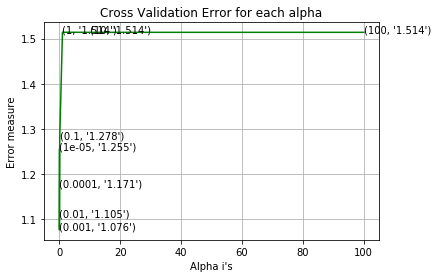

For values of best alpha =  0.001 The train log loss is: 0.5449989808318916
For values of best alpha =  0.001 The cross validation log loss is: 1.0760389769068355
For values of best alpha =  0.001 The test log loss is: 1.1234886732305278


In [242]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h3>4.4.2. Testing model with best hyper parameters</h3>

Log loss : 1.1234886732305278
Number of mis-classified points : 0.362406015037594

-------------------- Confusion matrix --------------------


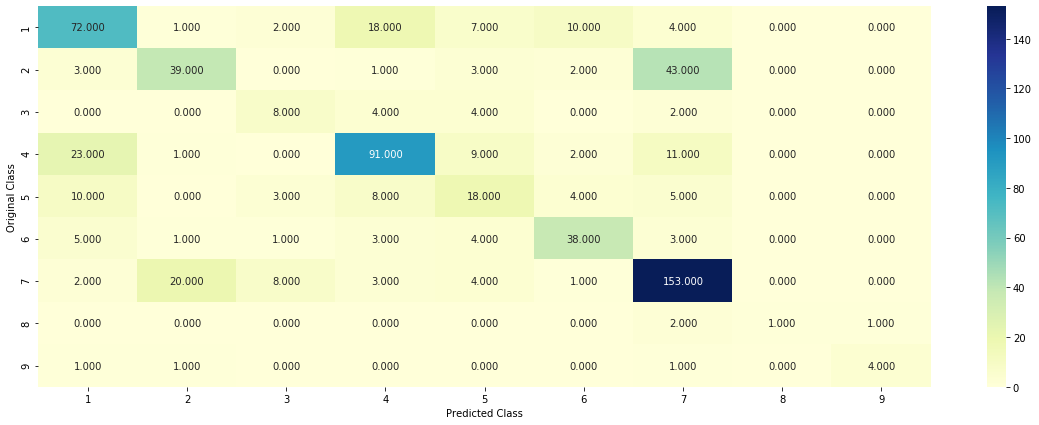

-------------------- Precision matrix (Columm Sum=1) --------------------


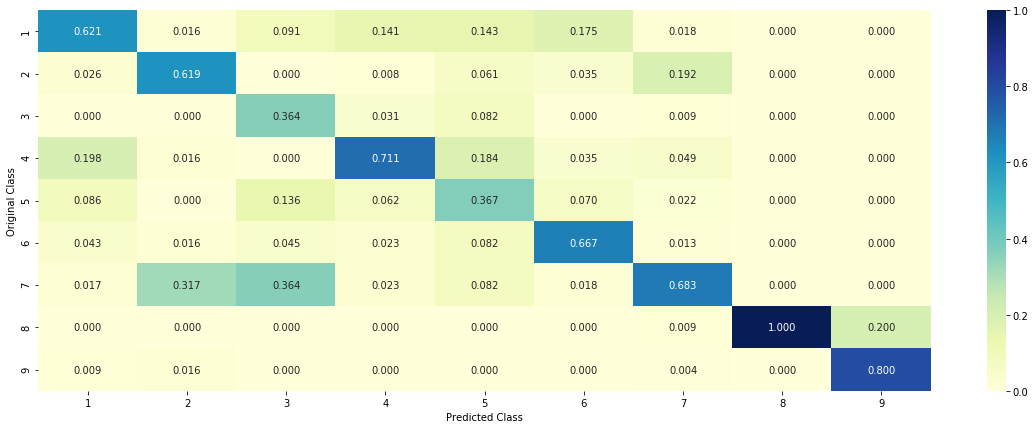

-------------------- Recall matrix (Row sum=1) --------------------


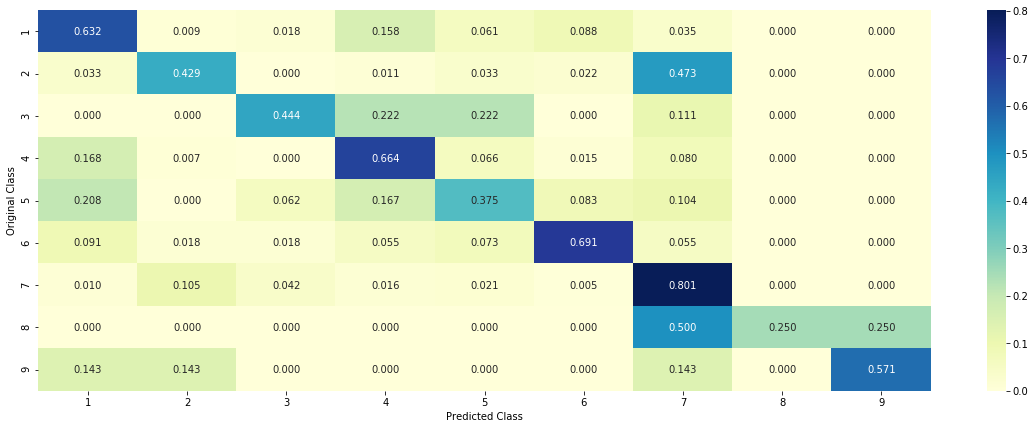

In [243]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x, train_y,test_x,test_y, clf)

<h3>4.3.3. Feature Importance</h3>

<h4>4.3.3.1. For Correctly classified point</h4>

In [246]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 1000
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index],
                     no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0058 0.0472 0.0079 0.0904 0.0099 0.7626 0.0679 0.0042 0.004 ]]
Actual Class : 6
--------------------------------------------------
230 Text feature [logged] present in test data point [True]
252 Text feature [amplification] present in test data point [True]
280 Text feature [fails] present in test data point [True]
299 Text feature [split] present in test data point [True]
389 Text feature [leaves] present in test data point [True]
416 Text feature [relation] present in test data point [True]
510 Text feature [s80] present in test data point [True]
517 Text feature [spermatogenesis] present in test data point [True]
587 Text feature [jo] present in test data point [True]
626 Text feature [weakened] present in test data point [True]
671 Text feature [triazole] present in test data point [True]
693 Text feature [salt] present in test data point [True]
698 Text feature [theoretical] present in test data point [True]
711 Text feature [

<h4>4.3.3.2. For Incorrectly classified point</h4>

In [249]:
test_point_index = 7
no_feature = 1000
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.2134 0.0935 0.0193 0.0256 0.5338 0.0077 0.0862 0.0127 0.0078]]
Actual Class : 2
--------------------------------------------------
186 Text feature [cystectomy] present in test data point [True]
221 Text feature [organs] present in test data point [True]
244 Text feature [radical] present in test data point [True]
252 Text feature [passaged] present in test data point [True]
297 Text feature [253j] present in test data point [True]
302 Text feature [outcomes] present in test data point [True]
303 Text feature [improvements] present in test data point [True]
441 Text feature [protrusions] present in test data point [True]
517 Text feature [limitations] present in test data point [True]
564 Text feature [tccsup] present in test data point [True]
649 Text feature [refseq] present in test data point [True]
676 Text feature [improved] present in test data point [True]
702 Text feature [hydrocortisone] present in test data point [True]
7

<h2>4.5 Random Forest Classifier</h2>

<h3>4.5.1. Hyper paramter tuning </h3>

In [250]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2510584898884678
for n_estimators = 100 and max depth =  10
Log Loss : 1.1685569757320364
for n_estimators = 200 and max depth =  5
Log Loss : 1.2415556032369135
for n_estimators = 200 and max depth =  10
Log Loss : 1.1661803490218476
for n_estimators = 500 and max depth =  5
Log Loss : 1.2320054008083732
for n_estimators = 500 and max depth =  10
Log Loss : 1.1615217374214324
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2300518997356313
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1659507309563337
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2300961672178445
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1668706478039623
For values of best estimator =  500 The train log loss is: 0.6479884277452452
For values of best estimator =  500 The cross validation log loss is: 1.1615217374214324
For values of best estimator =  500 The test log loss is: 1.1803379212049405


<h3>4.5.2. Testing model with best hyper parameters </h3>

Log loss : 1.1803379212049405
Number of mis-classified points : 0.3849624060150376

-------------------- Confusion matrix --------------------


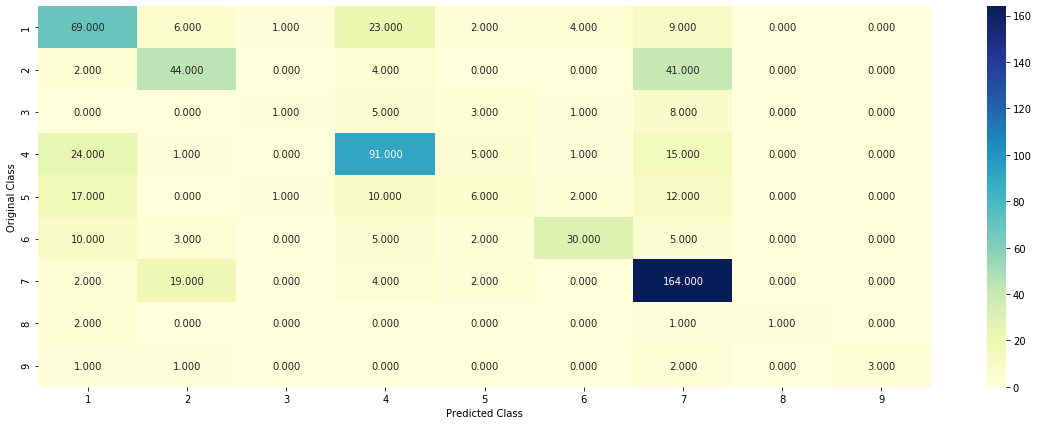

-------------------- Precision matrix (Columm Sum=1) --------------------


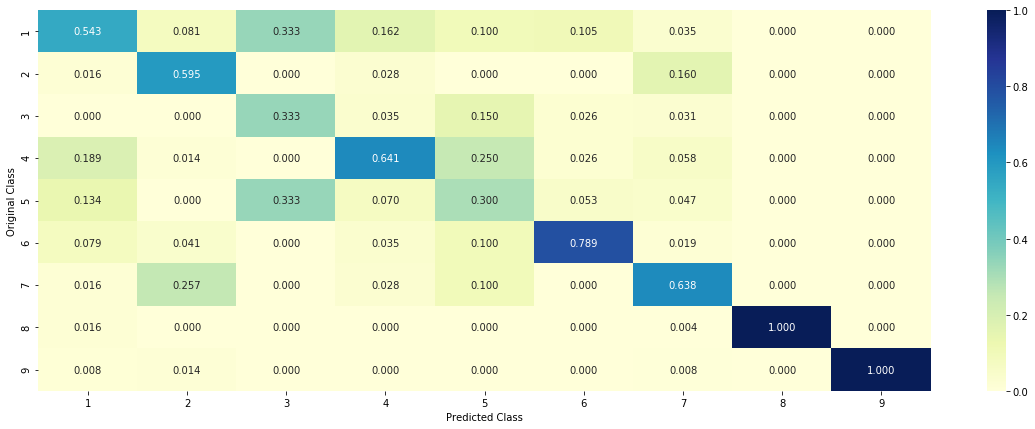

-------------------- Recall matrix (Row sum=1) --------------------


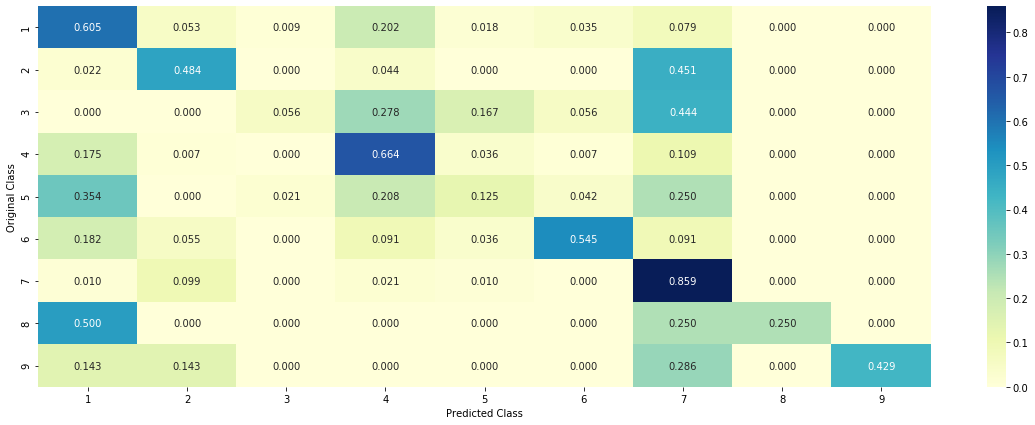

In [251]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x, train_y,test_x,test_y, clf)

<h3>4.5.3. Feature Importance</h3>

<h4>4.5.3.1. Correctly Classified point</h4>

In [252]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, train_y)

test_point_index = 1
no_feature = 1000
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0348 0.0209 0.0146 0.0371 0.0387 0.8272 0.0192 0.0031 0.0044]]
Actual Class : 6
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
2 Text feature [activation] present in test data point [True]
3 Text feature [inhibitor] present in test data point [True]
4 Text feature [inhibitors] present in test data point [True]
5 Text feature [tyrosine] present in test data point [True]
8 Text feature [loss] present in test data point [True]
9 Text feature [suppressor] present in test data point [True]
14 Text feature [nonsense] present in test data point [True]
17 Text feature [pathogenic] present in test data point [True]
18 Text feature [function] present in test data point [True]
20 Text feature [growth] present in test data point [True]
24 Text feature [missense] present in test data point [True]
25 Text feature [cells] present in test data point [True]
26 Text feature [oncogenic] pr

<h4>4.5.3.2. Inorrectly Classified point</h4>

In [253]:
test_point_index = 15
no_feature = 1000
predicted_cls = sig_clf.predict(test_x[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], 
                     x_test['TEXT'].iloc[test_point_index],
                     x_test['Gene'].iloc[test_point_index],
                     x_test['Variation'].iloc[test_point_index], 
                     no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5591 0.0273 0.0185 0.1034 0.1963 0.0595 0.0248 0.0046 0.0063]]
Actuall Class : 5
--------------------------------------------------
8 Text feature [loss] present in test data point [True]
9 Text feature [suppressor] present in test data point [True]
14 Text feature [nonsense] present in test data point [True]
17 Text feature [pathogenic] present in test data point [True]
18 Text feature [function] present in test data point [True]
24 Text feature [missense] present in test data point [True]
25 Text feature [cells] present in test data point [True]
29 Text feature [patients] present in test data point [True]
33 Text feature [brca1] present in test data point [True]
37 Text feature [variant] present in test data point [True]
42 Text feature [expressing] present in test data point [True]
47 Text feature [variants] present in test data point [True]
57 Text feature [clinical] present in test data point [True]
58 Text feature [brca2] pre

# Result

In [1]:
print()
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = "*** Model Summary *** [Performance Metric: Log-Loss]"
ptable.field_names=["Model Name","Train","CV","Test","% Misclassified Points"]
ptable.add_row(["Naive Bayes","0.94","1.21","1.24","43"])
ptable.add_row(["KNN","0.99","1.28","1.33","44"])
ptable.add_row(["Logistic Regression With Class balancing","0.50","1","1.08","37"])
ptable.add_row(["Logistic Regression Without Class balancing","0.5","1.03","1.09","36"])
ptable.add_row(["Linear SVC With Class Balancing","0.54","1.07","1.12","36"])
ptable.add_row(["Random Forest Classifier","0.65","1.16","1.18","38"])


print(ptable)
print()


+--------------------------------------------------------------------------------------------+
|                    *** Model Summary *** [Performance Metric: Log-Loss]                    |
+---------------------------------------------+-------+------+------+------------------------+
|                  Model Name                 | Train |  CV  | Test | % Misclassified Points |
+---------------------------------------------+-------+------+------+------------------------+
|                 Naive Bayes                 |  0.94 | 1.21 | 1.24 |           43           |
|                     KNN                     |  0.99 | 1.28 | 1.33 |           44           |
|   Logistic Regression With Class balancing  |  0.50 |  1   | 1.08 |           37           |
| Logistic Regression Without Class balancing |  0.5  | 1.03 | 1.09 |           36           |
|       Linear SVC With Class Balancing       |  0.54 | 1.07 | 1.12 |           36           |
|           Random Forest Classifier          |  

From the above summary table we can evaluate that 'Logistic Regression With Class balancing' is the best model with the lowest log loss among all the models.